In [6]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Load the dataset
df = pd.read_csv('Ecommerce_customer_data.csv')


In [7]:
# Step 1: Data Preprocessing

# Handle missing values
print("Missing values per column:\n", df.isnull().sum())

# Check if df is empty before dropping rows
if df.empty:
    print("DataFrame is empty after loading the CSV. Please check your data file.")
else:
    df.dropna(inplace=True)
    if df.empty:
        print("DataFrame is empty after dropping rows with missing values. Please review your missing data handling strategy.")
    else:
        # Convert categorical variables to numerical using one-hot encoding
        df = pd.get_dummies(df, drop_first=True)

        # Feature scaling
        scaler = StandardScaler()
        numerical_features = df.select_dtypes(include=[np.number]).columns
        df[numerical_features] = scaler.fit_transform(df[numerical_features])

Missing values per column:
 Customer ID                 0
Gender                      0
Age                         0
City                        0
Membership Type             0
Total Spend                 0
Items Purchased             0
Average Rating              0
Discount Applied            0
Days Since Last Purchase    0
Satisfaction Level          2
dtype: int64


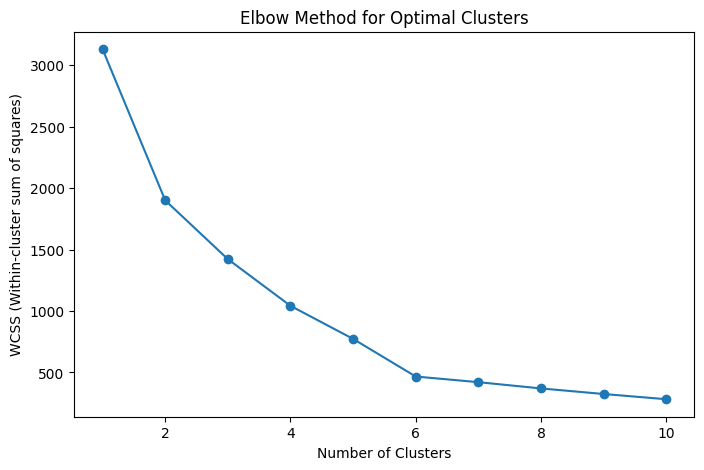

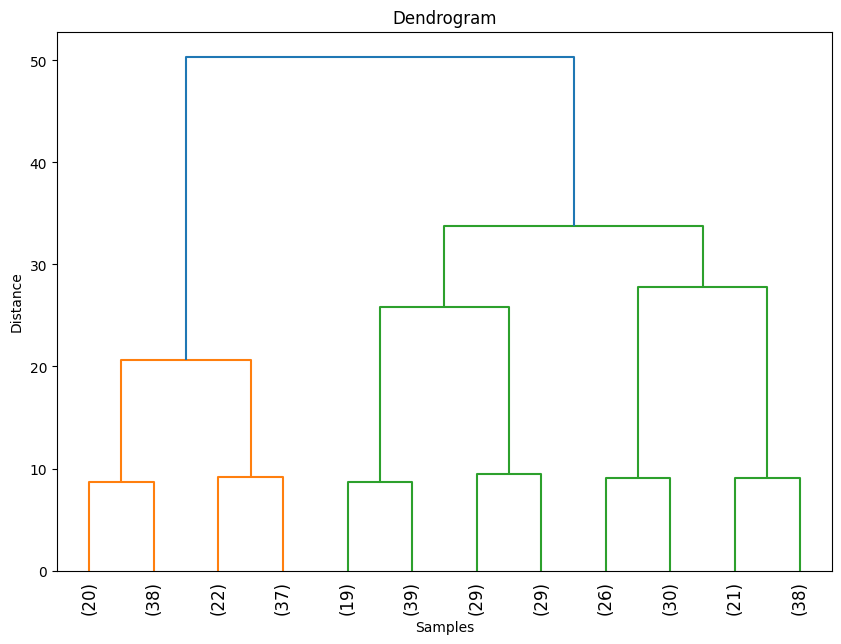

In [9]:
# Step 2: Clustering Techniques
# K-means Clustering
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(df)
    wcss.append(kmeans.inertia_)
# Plot the Elbow graph
plt.figure(figsize=(8, 5))
plt.plot(range(1, 11), wcss, marker='o')
plt.title("Elbow Method for Optimal Clusters")
plt.xlabel("Number of Clusters")
plt.ylabel("WCSS (Within-cluster sum of squares)")
plt.show()
# Fit K-means with the optimal number of clusters
optimal_clusters = 4  # Based on the elbow point in the plot
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
df['KMeans_Cluster'] = kmeans.fit_predict(df)
# Hierarchical Clustering
# Using dendrogram to visualize clusters and determine the optimal number of clusters
linked = linkage(df, method='ward')
plt.figure(figsize=(10, 7))
dendrogram(linked, truncate_mode='lastp', p=12, leaf_rotation=90, leaf_font_size=12)
plt.title("Dendrogram")
plt.xlabel("Samples")
plt.ylabel("Distance")
plt.show()
# Fit hierarchical clustering with optimal clusters
# Remove the 'affinity' parameter when using 'ward' linkage
hierarchical = AgglomerativeClustering(n_clusters=optimal_clusters, linkage='ward')
df['Hierarchical_Cluster'] = hierarchical.fit_predict(df)


Profile of Cluster 0:
Customer ID                       0.030941
Age                               0.640287
Total Spend                      -1.107906
Items Purchased                  -1.218057
Average Rating                   -1.439520
Discount Applied                  0.000000
Days Since Last Purchase         -0.284587
Gender_Male                       0.000000
City_Houston                      1.000000
City_Los Angeles                  0.000000
City_Miami                        0.000000
City_New York                     0.000000
City_San Francisco                0.000000
Membership Type_Gold              0.000000
Membership Type_Silver            0.000000
Satisfaction Level_Satisfied      0.000000
Satisfaction Level_Unsatisfied    0.000000
KMeans_Cluster                    0.000000
Hierarchical_Cluster              3.000000
dtype: float64
Size of cluster: 56

Profile of Cluster 1:
Customer ID                      -0.013002
Age                              -0.750257
Total Spend     

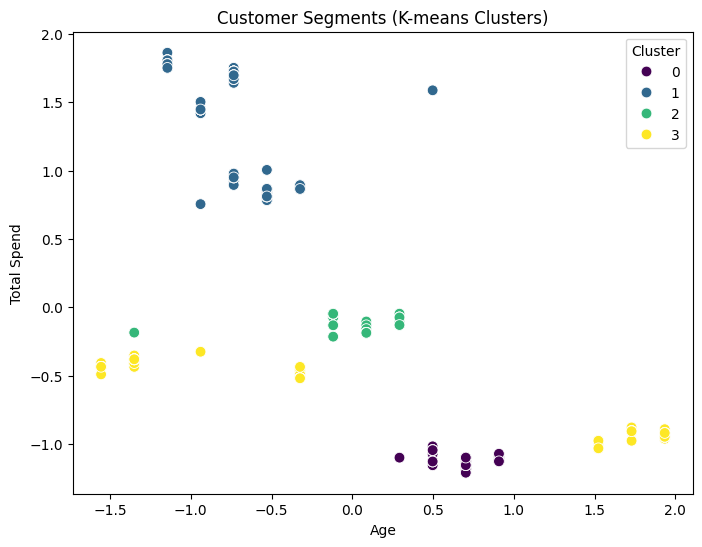

In [14]:
# Step 3: Profiling Customer Segments

# Analyze the K-means clusters (similar approach for hierarchical clusters)
for i in range(optimal_clusters):
    print(f"\nProfile of Cluster {i}:")
    print(df[df['KMeans_Cluster'] == i].mean())  # Mean profile of the cluster
    print("Size of cluster:", len(df[df['KMeans_Cluster'] == i]))

# Visualize clusters based on two features (e.g., Age and Total Spend)
plt.figure(figsize=(8, 6))
sns.scatterplot(x=df['Age'], y=df['Total Spend'], hue=df['KMeans_Cluster'], palette="viridis", s=60)
plt.title("Customer Segments (K-means Clusters)")
plt.xlabel("Age")
plt.ylabel("Total Spend")
plt.legend(title="Cluster")
plt.show()

In [13]:
# Step 4: Predictive Modeling for Each Segment

# For demonstration, let’s build a predictive model for each K-means segment

# Split data for each segment and train a model
segment_models = {}
for segment in range(optimal_clusters):
    segment_df = df[df['KMeans_Cluster'] == segment].copy()

    # Define the target and features (for this example, let’s predict 'Spending_Score' if it's available)
    if 'Spending_Score' in segment_df.columns:
        X = segment_df.drop(['Spending_Score', 'KMeans_Cluster', 'Hierarchical_Cluster'], axis=1)
        y = segment_df['Spending_Score'] > 0  # Example: High spender (binary classification)

        # Split data into training and testing sets
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

        # Train a simple model (e.g., RandomForest)
        model = RandomForestClassifier(random_state=42)
        model.fit(X_train, y_train)

        # Store the model
        segment_models[segment] = model

        # Evaluate the model
        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        print(f"Segment {segment} - Model Accuracy: {accuracy:.2f}")